## Combine the OHC files into one

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import netCDF4
from netCDF4 import Dataset

import xarray as xr
import glob, os
#print(xr.__version__)

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree() # The OG Data is in pc projection.

In [ ]:
os.chdir("/d6/bxw2101/oras5_ohc")
ohc_cons = glob.glob("consolidated/sohtc300_control_monthly_highres_2D_*.nc")
ohc_op = glob.glob("operational/sohtc300_control_monthly_highres_2D_*.nc")
all_ohc_files = ohc_cons + ohc_op
all_ohc_files.sort()
print("# of monthly files: " + str(len(all_ohc_files)))

In [ ]:
# ds_all = xr.open_mfdataset(all_ohc_files, concat_dim='time_counter', combine='nested')
#all righty this doesn't take a year.

In [ ]:
# ds_crop = ds_all.where(ds_all.nav_lat < -50)
# ds_crop.to_netcdf('all_ohc_monthly.nc', mode='w',format='NETCDF4')
#ok, this took a while lol.

## Doin stuff w the big netcdf file

In [2]:
filename = '/d6/bxw2101/oras5_ohc/all_ohc_monthly.nc'
ds = xr.open_dataset(filename, decode_times=False)

date_1 = datetime.datetime.strptime("01/16/1978", "%m/%d/%Y")
def convert_times(x):
  return (date_1 + relativedelta(hours=int(x))).replace(day=1, hour=0)
convert_times_v = np.vectorize(convert_times)
ds = ds.assign_coords(time_counter=convert_times_v(ds.time_counter))
ds = ds.rename({'time_counter': 'tdim'})

# Dataset notes:
# y: indices 0 to 1021. x: indices 0 to 1441.
# for nav_lat and nav_lon: it's in the format of (y, x). origin is bottom left.
# longitude, AFAIK, roughly increases by 0.25 degrees each increment. roughly.
# I have already cropped using .where() to just include latitudes < -50 degrees for the southern ocean.

In [5]:
ds

<xarray.Dataset>
Dimensions:   (tdim: 533, y: 1021, x: 1442)
Coordinates:
    nav_lat   (y, x) float32 ...
    nav_lon   (y, x) float32 ...
  * tdim      (tdim) datetime64[ns] 1978-01-01 1978-02-01 ... 2022-05-01
Dimensions without coordinates: y, x
Data variables:
    sohtc300  (tdim, y, x) float32 ...
Attributes:
    Conventions:  CF-1.4
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    title:        Monthly mean 2D fields
    source:       ORAS5 - backward extension (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...

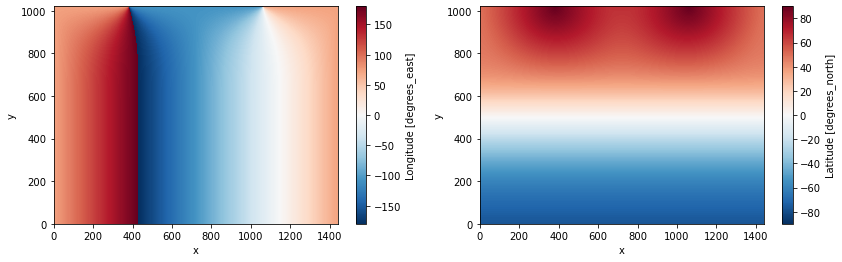

In [6]:
# Just plotting nav_lon and nav_lat. they are two-dimensional scalar fields. (obv)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
ds.nav_lon.plot(ax=ax1)
ds.nav_lat.plot(ax=ax2)

In [ ]:
ohc = ds.sohtc300
# The unites are: J/m2. Values can get to e10 range.
clim_period = ds.sel(tdim=slice('1979-01-01', '2021-12-01'))

## Tryna build a new OHC dataset that is 2x2 lon/lat.

In [ ]:
# Building the new dataset takes a while. There are a bunch of lat/lon combinations to go through.
# This code takes the NEAREST

# tdim: 516, Y: 20, X: 180 IS OUR DIMENSIONS.
lat_bins = np.arange(-88., -49, 2)
lon_bins = np.arange(0., 359, 2)
building_data = np.empty([20, 180, 533])
#y, x, tdim is our order of dimensions.

for lat in lat_bins:
    for lon in lon_bins:
        # First, find the index of the grid point nearest a specific lat/lon.
        
        # convert 180 to 358 to -180 to -2.
        if lon > 179:
            lon = lon - 360
        
        abslat = np.abs(ds.nav_lat-lat)
        abslon = np.abs(ds.nav_lon-lon)

        c = abslon**2 +  abslat**2

        (ypts, xpts) = np.where(c == np.min(c))
        yloc = ypts[0]
        xloc = xpts[0]

        # Now I can use that index location to get the values at the x/y diminsion
        point_ds = ds.isel(x=xloc, y=yloc)
        point_ds = point_ds.assign_coords({"y": lat, "x": lon})
        #print(point_ds)

        yi = int((lat + 88) / 2)
        xi = int(lon / 2)

        building_data[yi][xi] = point_ds.sohtc300.values

In [ ]:
times = ds.tdim.values
regridded_ohc = xr.DataArray(building_data, coords=[lat_bins, lon_bins, times], dims=['y', 'x', 'tdim'])
new_ds = xr.Dataset(data_vars = {"ohc": regridded_ohc})
new_ds = new_ds.transpose("tdim", "y", "x")
new_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/new_ohc_monthly_2x2.nc', mode='w',format='NETCDF4')
# regridded_ohc here is the new!

## Climatology and anomaly w/ the original coords: ohc_anom is the dataarray

In [ ]:
#getting the climatology: from 1979-2021. for now.
# WE WILL NO LONGER DO THE PERIOD FROM 1971-2000. WE WILL DO 1979-2021.
#clim_period = clim_period.sel(tdim=slice('1971-01-01', '2000-12-01'))
clim_ohc = clim_period.sohtc300

ohc_mon = ohc.groupby('tdim.month')
ohc_clim = clim_ohc.groupby('tdim.month').mean(dim='tdim')
ohc_anom = ohc_mon - ohc_clim
ohc_anom = ohc_anom.drop_vars('month')

In [ ]:
sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree() # The OG Data is in pc projection.

# Plotting all 12 month's climatologies.
ohc_clim
fig = plt.figure(figsize=(20, 15))
for m in range(1, 13):
    mclim = ohc_clim.sel(month=m)
    ax = plt.subplot(3, 4, m, projection=sp)
    mclim.plot.pcolormesh(
        ax=ax, transform=pc, x="nav_lon", y="nav_lat", add_colorbar=False
    )
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    
fig.suptitle("Climatology for the Ocean Heat Content <300m in the Antarctic")
# The climatology looks very similar across all of the months. That is okay! We will normalize

In [ ]:
#june climatology
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
(ohc_clim.sel(month=6)).plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat", # This gon be the way we plot this stuff.
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
#may climatology
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
(ohc_clim.sel(month=5)).plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat", # This gon be the way we plot this stuff.
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
#june - may climatology
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
(ohc_clim.sel(month=6) - ohc_clim.sel(month=5)).plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat", # This gon be the way we plot this stuff.
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

In [ ]:
# Graphing a singular month's anomaly
arb_anom_time = ohc_anom.sel(tdim='2017-11-01')[0]
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_anom_time.plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat", # This gon be the way we plot this stuff.
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

In [ ]:
#Graphing a single frame's absolute OHC values
arb_time = ohc.sel(tdim='2017-11-01')
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_time[0].plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat", # This gon be the way we plot this stuff.
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

## doing stuff w the 2x2 latitude longitude grid. PLOT LIKE THE SST FILES. Calculating the anomaly here.

using regridded_ohc, aka the dataset stored in '/d6/bxw2101/combined_netcdf_files/new_ohc_monthly_2x2.nc'

In [2]:
filename = '/d6/bxw2101/combined_netcdf_files/new_ohc_monthly_2x2.nc'
r_ds = xr.open_dataset(filename)
r_ohc = r_ds.ohc

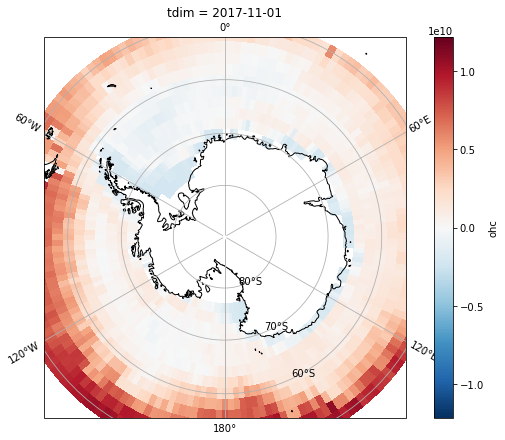

In [4]:
# NEW REGRIDDED OHC.
arb_time_regrid = r_ohc.sel(tdim='2017-11-01')
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_time_regrid.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

In [5]:
r_clim_period = r_ds.sel(tdim=slice('1979-01-01', '2021-12-01'))
r_clim_ohc = r_clim_period.ohc

r_ohc_mon = r_ohc.groupby('tdim.month')
r_ohc_clim = r_clim_ohc.groupby('tdim.month').mean(dim='tdim')
r_ohc_anom = r_ohc_mon - r_ohc_clim
r_ohc_anom = r_ohc_anom.drop_vars('month')

In [7]:
ohc_anom_ds = xr.Dataset(data_vars = {"ohc_anom": r_ohc_anom})
ohc_anom_ds = ohc_anom_ds.sel(tdim=slice('1979-01-01', '2021-12-01'))
ohc_anom_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/ohc_anom_monthly_2x2.nc', mode='w',format='NETCDF4')
#YAY WE HAVE THE OHC ANOMALY.

In [ ]:
# NEW REGRIDDED OHC ANOMALY
arb_anom_r = r_ohc_anom.sel(tdim='2017-11-01')
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_anom_r.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

# OLD FINE OHC ANOMALY
arb_anom_time = ohc_anom.sel(tdim='2017-11-01')[0]
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_anom_time.plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat", # This gon be the way we plot this stuff.
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

## Some stuff w/ ohc60, ohc75, just for plotting purposes.

In [ ]:
ds

In [ ]:
ds_crop = ds.where(ds.nav_lat < -50, drop=True)

In [ ]:
# Tryna figure out where tf damn vertical bar is coming from. i have no clue.
ohc60 = ds.where(ds.nav_lat < -50).sohtc300 # this is just increasing 
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
ohc60[0].plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat",
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

# Okay. I think everything is fine except the damn vertical line at long=0. not sure what to do with that.

In [ ]:
ohc60[0].plot()

In [ ]:
# Tryna figure out where tf damn vertical bar is coming from. i have no clue.
# Vert bar coming from when longitude = 0.
ohc75 = ds.where(ds.nav_lat < -75).sohtc300
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
ohc75[0].plot.pcolormesh(
    ax=ax, transform=pc, x="nav_lon", y="nav_lat",
)
ax.coastlines()
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

# OKAY THOUGH WHY TF IS THE HEAT CONTENT VALUES CHANGING DEPENDING ON THE .WHERE(LATITUDE)??? MAKES NO SENSE LMAO.
# 

In [ ]:
ohc75[0].plot()